In [143]:
# importing libraries
import numpy as np
import pandas as pd
from PIL import Image
import torch
import tensorflow as tf
import torchvision
from torchvision import transforms
from torchvision import datasets, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import pickle as pkl
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import sklearn
import seaborn as sns
import cv2
import skimage.exposure
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [80]:
csv_data = pd.read_csv('./blocks-labels.csv')
print(csv_data.shape)
print(csv_data[:3])
print('Number of stable:',np.count_nonzero(csv_data.stable==1))
print('Number of unstable:',np.count_nonzero(csv_data.stable==0))

# get the shuffle csv
shuffled_csv = sklearn.utils.shuffle(csv_data)

(51276, 2)
   id  stable
0   1       1
1   2       1
2   3       1
Number of stable: 27034
Number of unstable: 24242


In [84]:
print(shuffled_csv[:3])
X = shuffled_csv.id
Y = shuffled_csv.stable
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.3)


          id  stable
40912  40913       1
20722  20723       1
17880  17881       0


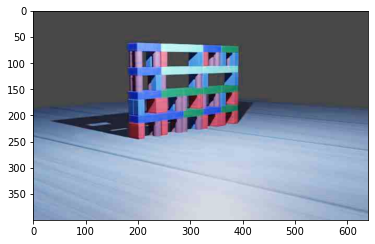

In [56]:
# load image
img = cv2.imread('./archive/23.jpg')
# fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(img)

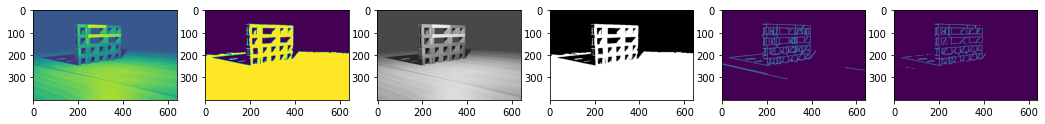

In [47]:
### image processing 
# take out background, remove light 
# increase contrast, maybe rgb vs greyscale? 

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY)[1]

# put mask on back
mask_back = cv2.cvtColor(gray, cv2.COLOR_BGR2BGRA)

mask_thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2BGRA)

# canny edge 
edges = cv2.Canny(img,100,230)
edges1 = cv2.Canny(img,230,250)

fig, ax = plt.subplots(1,6,figsize=(18, 18))

ax[0].imshow(gray)
ax[1].imshow(thresh)
ax[2].imshow(mask_back)
ax[3].imshow(mask_thresh)
ax[4].imshow(edges)
ax[5].imshow(edges1)


In [51]:
print(img.shape)

(400, 640, 3)


In [150]:
import PIL
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = AlexTransform):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        # self.class2index = {0:0, "1":1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        filename = str(self.df.id[index])+'.jpg'
        # print(self.class2index[1])
        # print(self.df.stable[index])
        # print(self.class2index[self.df.stable[index]])
        label = self.df.stable[index]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

train_dataset = CustomDataset("blocks-labels.csv", './archive'  )
print(train_dataset[3])

(tensor([[[ 0.4922,  0.4922,  0.4922,  ...,  0.4922,  0.4922,  0.4922],
         [ 0.4922,  0.4922,  0.4922,  ...,  0.4922,  0.4922,  0.4922],
         [ 0.4922,  0.4922,  0.4922,  ...,  0.4922,  0.4922,  0.4922],
         ...,
         [ 0.2504,  0.2504,  0.2504,  ...,  0.5686,  0.5559,  0.5559],
         [ 0.2504,  0.2504,  0.2504,  ...,  0.5686,  0.5559,  0.5559],
         [ 0.2504,  0.2504,  0.2504,  ...,  0.5686,  0.5559,  0.5559]],

        [[ 0.4922,  0.4922,  0.4922,  ...,  0.4922,  0.4922,  0.4922],
         [ 0.4922,  0.4922,  0.4922,  ...,  0.4922,  0.4922,  0.4922],
         [ 0.4922,  0.4922,  0.4922,  ...,  0.4922,  0.4922,  0.4922],
         ...,
         [ 0.0340,  0.0340,  0.0340,  ...,  0.3395,  0.3268,  0.3268],
         [ 0.0340,  0.0340,  0.0340,  ...,  0.3395,  0.3268,  0.3268],
         [ 0.0340,  0.0340,  0.0340,  ...,  0.3395,  0.3268,  0.3268]],

        [[ 0.4922,  0.4922,  0.4922,  ...,  0.4922,  0.4922,  0.4922],
         [ 0.4922,  0.4922,  0.4922,  ...,  

In [114]:
AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.ImageFolder('./', transform=AlexTransform)
print(dataset)

full_dataset = 51276

train_size = int(0.8 * full_dataset)
test_size = 51276 - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
print(trainloader)


Dataset ImageFolder
    Number of datapoints: 51276
    Root location: ./
    StandardTransform
Transform: Compose(
               Resize(size=(227, 227), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [90]:
# AlexNet
alex_net = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=False)
alex_net.classifier[6] = nn.Linear(4096,10)

Using cache found in /Users/christinekim/.cache/torch/hub/pytorch_vision_v0.9.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


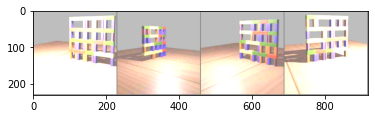

[tensor(1)] [tensor(1)] [tensor(1)] [tensor(1)]


In [106]:
print(trainloader)
dataiter = iter(trainloader)
images, labels = dataiter.next()
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % [labels[j]] for j in range(4)))

In [152]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alex_net.parameters(), lr=0.1, momentum=0.9)

for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataset, 0):
        # get the inputs; data is a list of [inputs, labels]
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        output = alex_net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
print('Finished Training of AlexNet')

[1,   200] loss: 0.000


KeyboardInterrupt: 